In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *


In [2]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```

All files for one case:

```
communityfile0.5_1.5_10.txt
communitysizesfile0.5_1.5_10.txt
degreefile0.5_1.5_10.txt
networkfile0.5_1.5_10.txt
```

All graph have 250 outlier nodes, mapped to community 0 below


In [3]:
path = '/data/ABCDoo/'
#path = '../Datasets/ABCDoo/'
def readGraph(xi=0.5, eta=1.5, rep=1):
    ## read edges, build graph
    fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [4]:
#oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable

## input format: 
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [5]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

In [15]:
from itertools import combinations
def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


In [38]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP or ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    ctr = 1
    for nm in names:
        if ctr%1000==0:
            print(ctr)
        ctr+=1
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


## Compare algorithms

* Leiden
* Ego-split
* CPM
* Chako??


In [46]:
Results = []
for eta in [1.0,1.5,2.0,2.5,3.0]:
    G = readGraph(xi=0.65, eta=eta, rep=1)
    G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
    GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
    GT = [[str(i) for i in x] for x in GT]
    CP = CPM(G)
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    LD = mems2comms([[x] for x in G.vs['leiden']])
    LD = [[str(i) for i in j] for j in LD]
    comms_es = EgoSplit(G, split='CC', algo='ECG')
    ES = [list(x) for x in comms_es if len(x)>=10]
    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    L = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            L.append(list(x))        
    X = [eta, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L)]
    print(X)
    Results.append(X)
    

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[1.0, 0.014876, 0.437344, 0.129208, 0.309174]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[1.5, 0.0240477, 0.0610172, 0.0718691, 0.124893]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[2.0, 0.0104652, -5.75417e-17, 0.0192535, 0.0364296]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[2.5, 0.00152287, -2.40898e-17, 0.00152335, 0.0]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[3.0, 4.25472e-17, 2.1198e-17, 1.06553e-17, 0.0]


In [47]:
_df = pd.DataFrame(Results, columns=['eta','cpm','leiden','ego','beta'])
_df['xi'] = 0.65
_df


,eta,cpm,leiden,ego,beta,xi
0,1.0,1.487600e-02,4.373440e-01,1.292080e-01,0.309174,0.65
1,1.5,2.404770e-02,6.101720e-02,7.186910e-02,0.124893,0.65
2,2.0,1.046520e-02,-5.754170e-17,1.925350e-02,0.036430,0.65
3,2.5,1.522870e-03,-2.408980e-17,1.523350e-03,0.000000,0.65
4,3.0,4.254720e-17,2.119800e-17,1.065530e-17,0.000000,0.65


In [48]:
Results = []
for eta in [1.0,1.5,2.0,2.5,3.0]:
    G = readGraph(xi=0.5, eta=eta, rep=1)
    G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
    GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
    GT = [[str(i) for i in x] for x in GT]
    CP = CPM(G)
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    LD = mems2comms([[x] for x in G.vs['leiden']])
    LD = [[str(i) for i in j] for j in LD]
    comms_es = EgoSplit(G, split='CC', algo='ECG')
    ES = [list(x) for x in comms_es if len(x)>=10]
    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    L = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            L.append(list(x))        
    X = [eta, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L)]
    print(X)
    Results.append(X)
    

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[1.0, 0.0627512, 0.945943, 0.424219, 0.593306]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[1.5, 0.0340607, 0.305801, 0.227708, 0.378483]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[2.0, 0.0365698, 0.160109, 0.135496, 0.250527]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[2.5, 0.00825558, 0.135069, 0.0226095, 0.0800586]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[3.0, 0.0010386, 0.105447, 0.00103905, 0.0116539]


In [49]:
__df = pd.DataFrame(Results, columns=['eta','cpm','leiden','ego','beta'])
__df['xi'] = 0.5
__df


,eta,cpm,leiden,ego,beta,xi
0,1.0,0.062751,0.945943,0.424219,0.593306,0.5
1,1.5,0.034061,0.305801,0.227708,0.378483,0.5
2,2.0,0.036570,0.160109,0.135496,0.250527,0.5
3,2.5,0.008256,0.135069,0.022610,0.080059,0.5
4,3.0,0.001039,0.105447,0.001039,0.011654,0.5


In [52]:
__df

,eta,cpm,leiden,ego,beta,xi
0,1.0,0.062751,0.945943,0.424219,0.593306,0.5
1,1.5,0.034061,0.305801,0.227708,0.378483,0.5
2,2.0,0.036570,0.160109,0.135496,0.250527,0.5
3,2.5,0.008256,0.135069,0.022610,0.080059,0.5
4,3.0,0.001039,0.105447,0.001039,0.011654,0.5


In [54]:
DF = pd.concat([df,__df,_df])

In [44]:
df = pd.DataFrame(Results, columns=['eta','cpm','leiden','ego','beta'])
df['xi'] = 0.35
df


,eta,cpm,leiden,ego,beta,xi
0,1.0,0.130833,0.953780,0.685790,0.758943,0.35
1,1.5,0.026291,0.327206,0.359753,0.526670,0.35
2,2.0,0.025080,0.159065,0.297404,0.367987,0.35
3,2.5,0.020799,0.137114,0.163895,0.248890,0.35
4,3.0,0.009458,0.116688,0.046508,0.155460,0.35


In [55]:
with open('algo_compare.pkl','wb') as fp:
    pickle.dump(DF,fp)

In [77]:
DF.columns = ['eta', 'CPM', 'Leiden', 'EgoSplit', 'EgoSplit+CAS', 'xi']

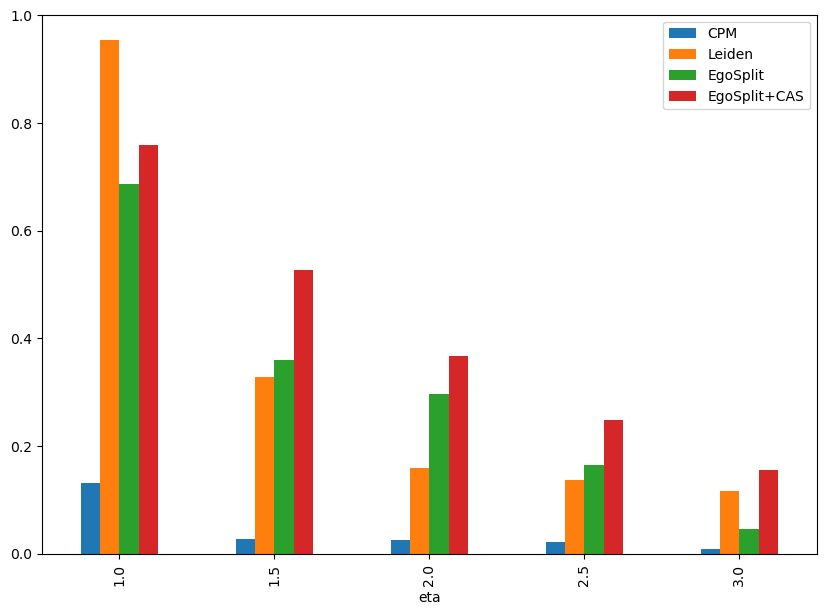

In [80]:
DF[DF.xi==.35].plot(x='eta',y=['CPM', 'Leiden', 'EgoSplit', 'EgoSplit+CAS'], kind='bar', figsize=(10,7));